In [114]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

In [94]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

In [95]:
# option to display the full text of the string columns
pd.set_option('display.max_colwidth', None)

In [96]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv')

In [97]:
# check for success
df1.head(2)

,Unnamed: 0,Respondent,MainBranch,Hobbyist,ConvertedComp,Country,DatabaseWorkedWith,DevType,EdLevel,Employment,...,PurpleLink,Stuck,OpSys,OrgSize,PlatformWorkedWith,UndergradMajor,WebframeWorkedWith,WorkWeekHrs,DevClass,imputedComp
0,0,1,I am a developer by profession,Yes,NaN,Germany,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;Developer, full-stack",Master’s degree,"Independent contractor, freelancer, or self-employed",...,Amused,Visit Stack Overflow;Go for a walk or other physical activity;Do other work and come back later,Windows,2 to 9 employees,Windows,Computer science,ASP.NET;ASP.NET Core,50.0,other_coder,62697.0
1,1,2,I am a developer by profession,No,NaN,United Kingdom,NaN,"Developer, full-stack;Developer, mobile",Bachelor’s degree,Employed full-time,...,Amused,Visit Stack Overflow;Go for a walk or other physical activity,MacOS,"1,000 to 4,999 employees",iOS,Computer science,NaN,NaN,other_coder,67215.0


## Education related information
I will address now the questions I am interested in: 
> Do data developers have more formal educational background than the other developers? In particular, are there more data coders that major in math or stats than other developers? How is the education level related to job satisfaction and compensation? 

The questions regarding the education that I am interested in are related to the columns `EdLevel`, '`NewEdImpt`, `UndergradMajor`. I am also interested in how these options are related to salary, i.e. `ConvertedComp` and `JobSat`.

## Formal education and the two classes of developers

### The education levels of data coders compared with the other coders

In [99]:
# get the question about education level
dfs[dfs.Column == 'EdLevel']['QuestionText']

14    Which of the following best describes the highest level of formal education that you’ve completed?
Name: QuestionText, dtype: object

In [100]:
# get the curated choices for the education level question
df1.EdLevel.unique()

array(['Master’s degree', 'Bachelor’s degree', 'Secondary school',
       'Professional degree', 'College study/no degree',
       'Associate degree', 'Other doctoral degree', nan,
       'Primary/elementary school', 'No formal education'], dtype=object)

In [101]:
# use groupby() to get the percentage of developers in each education level
EdLevel_perc = df1.groupby('DevClass')['EdLevel'].value_counts(normalize=True)
EdLevel_perc.round(4)*100

DevClass     EdLevel                  
data_coder   Bachelor’s degree            41.80
             Master’s degree              32.76
             College study/no degree       9.30
             Other doctoral degree         7.60
             Secondary school              3.27
             Associate degree              2.25
             Professional degree           1.52
             No formal education           0.77
             Primary/elementary school     0.72
other_coder  Bachelor’s degree            47.09
             Master’s degree              21.11
             College study/no degree      13.20
             Secondary school              9.12
             Associate degree              3.38
             Other doctoral degree         2.14
             Primary/elementary school     1.78
             Professional degree           1.35
             No formal education           0.82
Name: EdLevel, dtype: float64

In [102]:
# convert the series into a dataframe object
EdLevel_perc = EdLevel_perc.reset_index(name='perc')
EdLevel_perc

,DevClass,EdLevel,perc
0,data_coder,Bachelor’s degree,0.418010
1,data_coder,Master’s degree,0.327610
2,data_coder,College study/no degree,0.092969
3,data_coder,Other doctoral degree,0.076034
4,data_coder,Secondary school,0.032703
5,data_coder,Associate degree,0.022541
6,data_coder,Professional degree,0.015183
7,data_coder,No formal education,0.007708
8,data_coder,Primary/elementary school,0.007241
9,other_coder,Bachelor’s degree,0.470928


In [103]:
# rearrange the data to have two coder types as columns
EdLevel_perc = EdLevel_perc.pivot(index='EdLevel',columns='DevClass',values='perc')
EdLevel_perc

DevClass,data_coder,other_coder
EdLevel,,
Associate degree,0.022541,0.033828
Bachelor’s degree,0.418010,0.470928
College study/no degree,0.092969,0.132008
Master’s degree,0.327610,0.211126
No formal education,0.007708,0.008223
Other doctoral degree,0.076034,0.021389
Primary/elementary school,0.007241,0.017755
Professional degree,0.015183,0.013519
Secondary school,0.032703,0.091224


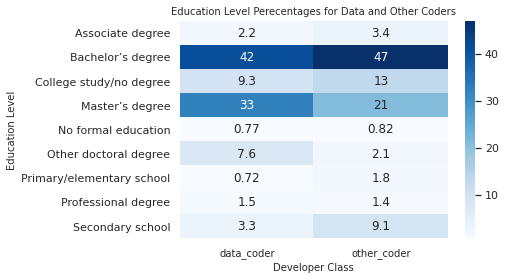

In [104]:
# plot the heatmap
sns.heatmap(EdLevel_perc.round(4)*100, cmap='Blues', annot = True);

# set labels, title, xticks properties
plt.xlabel('Developer Class', size=10)
plt.ylabel('Education Level', size=10)
plt.title('Education Level Perecentages for Data and Other Coders', size=10)
plt.xticks(size=10);


#### Comments on education levels:
We observe from this heat map, that the percentages of data coders with higher education degrees (Master, Doctoral or Professional) are higher than the corresponding percentages for the other developers, in particular Master and Other Doctoral degrees. Specifically, about 42% of data coders have a higher education degree, compared to only 24.5 % for the other coders. Almost half of the other coders have a Bachelor's degree, the corresponding percentage is lower among the data coders. 

### Are there more data coders with math and stats degrees than other coders?

In [105]:
# get the question about undergraduate degree
dfs[dfs.Column == 'UndergradMajor']['QuestionText']

54    What was your primary field of study?
Name: QuestionText, dtype: object

In [106]:
# get the curated choices for the field of study
df1.UndergradMajor.unique()

array(['Computer science', nan, 'Mathematics or statistics',
       'Engineering other', 'Humanities', 'Health science',
       'Information system', 'Web dev/design', 'Natural science', 'Arts',
       'No major', 'Social science', 'Business'], dtype=object)

In [107]:
# use groupby() to get the percentage of developers with each major
UndergradMajor_perc = df1.groupby('DevClass')['UndergradMajor'].value_counts(normalize=True)
UndergradMajor_perc = UndergradMajor_perc.round(4)*100

In [108]:
# convert the series into a dataframe object
UndergradMajor_perc = UndergradMajor_perc.reset_index(name='perc')
UndergradMajor_perc 

,DevClass,UndergradMajor,perc
0,data_coder,Computer science,51.88
1,data_coder,Engineering other,12.01
2,data_coder,Mathematics or statistics,8.03
3,data_coder,Information system,7.63
4,data_coder,Natural science,7.37
5,data_coder,Business,4.57
6,data_coder,Social science,3.27
7,data_coder,Humanities,1.83
8,data_coder,Web dev/design,1.48
9,data_coder,No major,0.73


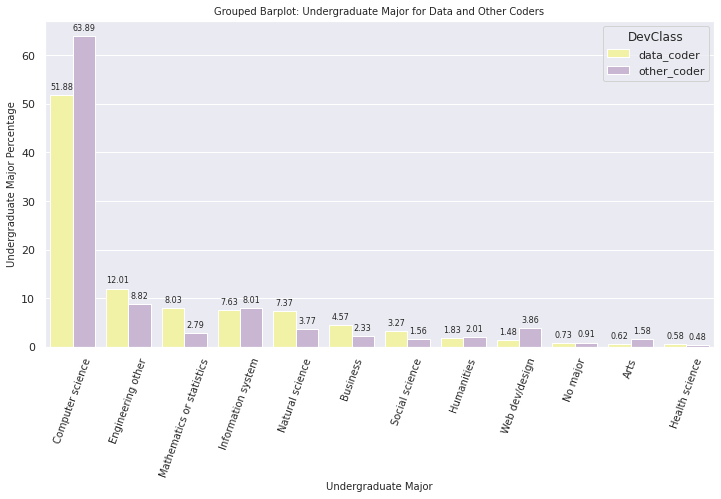

In [113]:
# set the figure size
plt.figure(figsize=(12, 6))

# create the plot
g=sns.barplot(data=UndergradMajor_perc, x='UndergradMajor', y='perc', hue='DevClass')

# set labels, title, xticks properties
plt.xlabel('Undergraduate Major', size=10)
plt.ylabel('Undergraduate Major Percentage', size=10)
plt.title('Grouped Barplot: Undergraduate Major for Data and Other Coders', size=10)
plt.xticks(size=10, rotation = 70);

# annotate the bars
for p in g.patches:
    g.annotate(p.get_height().round(2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8,
                   xytext = (0, 8), 
                   textcoords = 'offset points')

#### Comments on undergraduate majors
We see from our plot that the percentages of data coders with a mathematics or statistics degree, some engineering degree (other than computer science), or a science degree (both natural and social sciences) are higher than the corresponding values for developers that do not work with big data. However, the largest gap we observe for computer science graduates who form almost 64% of the other coders, compared with 52% for the data coders.

### Importance attributed to formal education

In [79]:
# get the question about the importance of formal education
dfs[dfs.Column == 'NEWEdImpt']['QuestionText']

29    How important is a formal education, such as a university degree in computer science, to your career?
Name: QuestionText, dtype: object

In [80]:
# get the choices for the education importance question
df1.EdImpt.unique()

array(['Fairly important', 'Not at all important/not necessary',
       'Very important', 'Somewhat important', nan,
       'Critically important'], dtype=object)

In [82]:
# use groupby() to get the percentage of developers with each major
EdImpt_perc = df1.groupby('DevClass')['EdImpt'].value_counts(normalize=True)
EdImpt_perc = EdImpt_perc.round(4)*100

In [83]:
# convert the series into a dataframe object
EdImpt_perc = EdImpt_perc.reset_index(name='perc')
EdImpt_perc 

,DevClass,EdImpt,perc
0,data_coder,Very important,28.63
1,data_coder,Fairly important,24.08
2,data_coder,Somewhat important,19.30
3,data_coder,Critically important,15.27
4,data_coder,Not at all important/not necessary,12.73
5,other_coder,Fairly important,26.60
6,other_coder,Somewhat important,24.40
7,other_coder,Very important,23.57
8,other_coder,Not at all important/not necessary,16.75
9,other_coder,Critically important,8.69


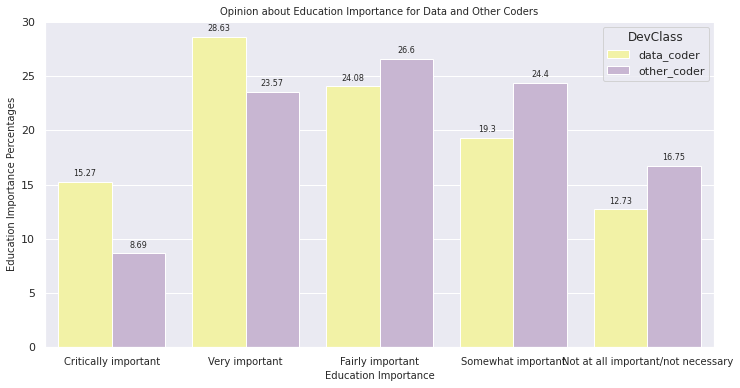

In [112]:
# set the figure size
plt.figure(figsize=(12, 6))

# create order for the bars 
opinions = ['Critically important', 'Very important', 'Fairly important', 
            'Somewhat important', 'Not at all important/not necessary']

# create the plot
g=sns.barplot(data=EdImpt_perc, x='EdImpt', y='perc', hue='DevClass',
             order = opinions)

# set labels, title, xticks properties
plt.xlabel('Education Importance', size=10)
plt.ylabel('Education Importance Percentages', size=10)
plt.title('Opinion about Education Importance for Data and Other Coders', size=10)
plt.xticks(size=10, rotation = 0);

# annotate the bars
for p in g.patches:
    g.annotate(p.get_height().round(2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8,
                   xytext = (0, 8), 
                   textcoords = 'offset points')

#### Comments on the importance of formal education:
There are higher percentages of data coders who considers a formal education critically or very important to their careers. On the other side, the other coders see a formal education only fairly important. 